In [146]:
#Φορτώνουμε τα libraries που θα χρησιμοποιήσουμε στο πρόγραμμα
import struct
import os
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import expit
import sys
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score

In [7]:
#Με την παρακάτω συνάρτηση ανοίγουμε το αρχείο MNIST
def load_mnist(path, kind='train'):
    labels_path = os.path.join(path, '%s-labels-idx1-ubyte' % kind)
    images_path = os.path.join(path, '%s-images-idx3-ubyte' % kind)
    
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', lbpath.read(8))
        labels = np.fromfile(lbpath, dtype=np.uint8)
        
    with open(images_path, 'rb') as imgpath:
        magic, num, row, cols = struct.unpack('>IIII', imgpath.read(16))
        images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 784)
        
    return images, labels

In [8]:
#Με τον παρακάτω κώδικα διαβάζουμε τα αρχεία με τις εικόνες προς εκπαίδευση
X_train, y_train = load_mnist('C:/Users/math/Desktop/Programming/DNN/Data/', kind = 'train')
X_train.shape

(60000, 784)

In [9]:
#Με τον παρακάτω κώδικα διαβάζουμε τα αρχεία με τις εικόνες του τεστ
X_test, y_test = load_mnist('C:/Users/math/Desktop/Programming/DNN/Data/', kind = 't10k')
X_test.shape

(10000, 784)

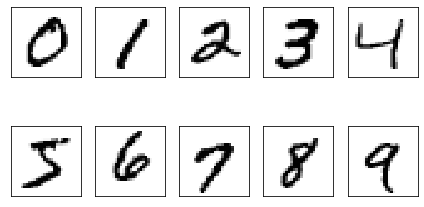

In [170]:
#Αναπαριστώ ένα δείγμα των αρχείων για να ελέγξω έαν έχει ανοίξει με σωστό τρόπο
fig, ax = plt.subplots(nrows = 2, ncols = 5, sharex = True, sharey = True)
ax = ax.flatten()
for i in range(10):
    img = X_train[y_train == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation = 'nearest')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

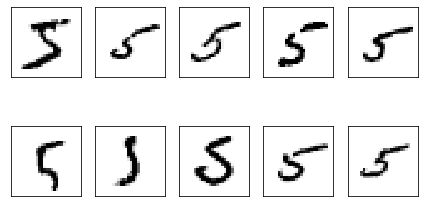

In [172]:
#Μπορούμε να επιλέξουμε και έναν μόνο αριθμό για να μας δείξει.
fig, ax = plt.subplots(nrows = 2, ncols = 5, sharex = True, sharey = True)
ax = ax.flatten()
for i in range(10):
    img = X_train[y_train == 5][i].reshape(28,28)
    ax[i].imshow(img, cmap = 'Greys', interpolation = 'nearest')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [173]:
#Δημιουργούμε την κλάση του νευρωνικού δικτύου
class NeuralNetwork(object):
    #Feedforward νευρωνικό δίκτυο
    def __init__(self, n_output, n_features, n_hidden=30, l1=0.0, l2=0.0, epochs=500, eta=0.001, alpha=0.0, decrease_const=0.0, shuffle=True, minibatches=1, random_state=None):
        np.random.seed(random_state)
        self.n_output = n_output
        self.n_features = n_features
        self.n_hidden = n_hidden
        self.w1, self.w2 = self._initialize_weights()
        self.l1 = l1
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches
 

    def _encode_labels(self, y, k):
        #Κωδικοποίηση των τίτλων σε one-hot αναπαράσταση
        onehot = np.zeros((k, y.shape[0]))
        for idx, val in enumerate(y):
            onehot[val, idx] = 1.0
        return onehot

    def _initialize_weights(self):
        #Αρχικοποίηση των βαρών με μικρούς τυχαίους αριθμούς
        w1 = np.random.uniform(-1.0, 1.0, size=self.n_hidden*(self.n_features + 1))
        w1 = w1.reshape(self.n_hidden, self.n_features + 1)
        w2 = np.random.uniform(-1.0, 1.0, size=self.n_output*(self.n_hidden + 1))
        w2 = w2.reshape(self.n_output, self.n_hidden + 1)
        return w1, w2
    
    def _sigmoid(self, z):
        #Υπολογισμός της logistic συνάρτησης
        return 1.0 / (1.0 + np.exp(-z))
        return expit(z)
    
    def _sigmoid_gradient(self, z):
        #Υπολογισμός της παραγώγου της logistic συνάρτησης
        sg = self._sigmoid(z)
        return sg * (1.0 - sg)
    
    def _add_bias_unit(self, X, how='column'):
        #Πρόσθεση μονάδας πόλωσης
        if how == 'column':
            X_new = np.ones((X.shape[0], X.shape[1] + 1))
            X_new[:, 1:] = X
        elif how == 'row':
            X_new = np.ones((X.shape[0] + 1, X.shape[1]))
            X_new[1:, :] = X
        else:
            raise AttributeError('`how` must be `column` or `row`')
        return X_new
    
    def _feedforward(self, X, w1, w2):
        #αλγόριθμος feedforward
        a1 = self._add_bias_unit(X, how='column')
        z2 = w1.dot(a1.T)
        a2 = self._sigmoid(z2)
        a2 = self._add_bias_unit(a2, how='row')
        z3 = w2.dot(a2)
        a3 = self._sigmoid(z3)
        return a1, z2, a2, z3, a3

    def _L2_reg(self, lambda_, w1, w2):
        #Υπολογισμός L2-regularization κόστος
        return (lambda_/2.0) * (np.sum(w1[:, 1:] ** 2) + np.sum(w2[:, 1:] ** 2))

    def _L1_reg(self, lambda_, w1, w2):
        #Υπολογισμός L1-regularization κόστος
        return (lambda_/2.0) * (np.abs(w1[:, 1:]).sum() + np.abs(w2[:, 1:]).sum())

    def _get_cost(self, y_enc, output, w1, w2):
        #Υπολογισμός συνάρτησης κόστους
        term1 = -y_enc * (np.log(output))
        term2 = (1.0 - y_enc) * np.log(1.0 - output)
        cost = np.sum(term1 - term2)
        L1_term = self._L1_reg(self.l1, w1, w2)
        L2_term = self._L2_reg(self.l2, w1, w2)
        cost = cost + L1_term + L2_term
        return cost

    def _get_gradient(self, a1, a2, a3, z2, y_enc, w1, w2):
        #Υπολογισμός της παραγώγου με backpropagation.
        
        # backpropagation
        sigma3 = a3 - y_enc
        z2 = self._add_bias_unit(z2, how='row')
        sigma2 = w2.T.dot(sigma3) * self._sigmoid_gradient(z2)
        sigma2 = sigma2[1:, :]
        grad1 = sigma2.dot(a1)
        grad2 = sigma3.dot(a2.T)

        # Κανονικοποίηση
        grad1[:, 1:] += self.l2 * w1[:, 1:]
        grad1[:, 1:] += self.l1 * np.sign(w1[:, 1:])
        grad2[:, 1:] += self.l2 * w2[:, 1:]
        grad2[:, 1:] += self.l1 * np.sign(w2[:, 1:])
        return grad1, grad2

    def predict(self, X):
        #Αλγόριθμος πρόβλεψης των τίτλων των κλάσεων
        if len(X.shape) != 2:
            raise AttributeError('X must be a [n_samples, n_features] array.\n'
                                'Use X[:,None] for 1-feaure classification,'
                                '\nor X[[1]] for 1-sample classification')
        a1, z2, a2, z3, a3 = self._feedforward(X, self.w1, self.w2)
        y_pred = np.argmax(z3, axis=0)
        return y_pred

    def fit(self, X, y, print_progress=False):
        #Αναθεώρηση των βαρών από τα δεδομένα εκπαίδευσης
        self.cost_ = []
        X_data, y_data = X.copy(), y.copy()
        y_enc = self._encode_labels(y, self.n_output)
        delta_w1_prev = np.zeros(self.w1.shape)
        delta_w2_prev = np.zeros(self.w2.shape)
        for i in range(self.epochs):
            # προσαρμοσμένος ρυθμός εκπαίδευσης
            self.eta /= (1 + self.decrease_const*i)
            if print_progress:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()
            if self.shuffle:
                idx = np.random.permutation(y_data.shape[0])
                X_data, y_enc = X_data[idx], y_enc[:, idx]
            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            for idx in mini:
                # feedforward
                a1, z2, a2, z3, a3 = self._feedforward(X_data[idx], self.w1, self.w2)
                cost = self._get_cost(y_enc=y_enc[:, idx], output=a3, w1=self.w1, w2=self.w2)
                self.cost_.append(cost)
                # υπολογισμός της παραγώγου μέσω backpropagation
                grad1, grad2 = self._get_gradient(a1=a1, a2=a2, a3=a3, z2=z2, y_enc=y_enc[:, idx], w1=self.w1, w2=self.w2)
                delta_w1, delta_w2 = self.eta * grad1, self.eta * grad2
                self.w1 -= (delta_w1 + (self.alpha * delta_w1_prev))
                self.w2 -= (delta_w2 + (self.alpha * delta_w2_prev))
                delta_w1_prev, delta_w2_prev = delta_w1, delta_w2
        return self


In [174]:
#αρχικοποιούμε το νευρωνικό δίκτυο με 784 εισόδους, 50 κρυμμένα στοιχεία και 10 output
nn = NeuralNetwork(n_output = 10, n_features = X_train.shape[1], n_hidden = 50, l2 = 0.1, l1 = 0.0, epochs = 1000, eta = 0.001, alpha = 0.001, decrease_const = 0.00001, minibatches = 50, shuffle = True, random_state = 1)
nn

In [175]:
#Εκπαίδευση του νευρωνικού δικτύου
nn.fit(X_train, y_train, print_progress = True)

Epoch: 1/1000C:\Users\math\AppData\Local\Temp/ipykernel_8176/1370522676.py:37: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-z))
Epoch: 1000/1000

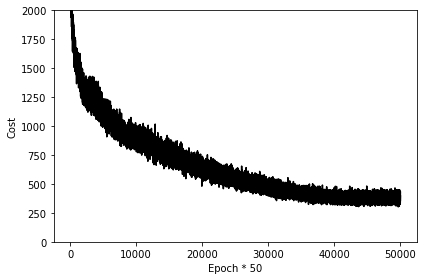

In [177]:
#Κατασκευάζουμε το διάγραμμη σύγκλισης του κόστους για κάθε 50 βήματα
plt.plot(range(len(nn.cost_)), nn.cost_, color = 'k')
plt.ylim([0, 2000])
plt.ylabel('Cost')
plt.xlabel('Epoch * 50')
plt.tight_layout()
plt.show()


In [178]:
#Αλγόριθμος για την αξιολόγηση του μοντέλου στο αρχείο με τα 60.000 δεδομένα
y_train_pred = nn.predict(X_train)
accuracy = \
    ((np.sum(y_train == y_train_pred, axis = 0)).astype('float') / X_train.shape[0])
accuracy

C:\Users\math\AppData\Local\Temp/ipykernel_8176/1370522676.py:37: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-z))


0.9753333333333334

In [179]:
#αλγόριθμος για την αξιολόγηση με τα 10.000 δεδομένα
y_test_pred = nn.predict(X_test)
accuracy = \
    ((np.sum(y_test == y_test_pred, axis = 0)).astype('float') / X_test.shape[0])
accuracy

C:\Users\math\AppData\Local\Temp/ipykernel_8176/1370522676.py:37: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-z))


0.9592

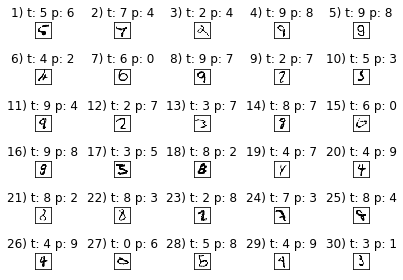

In [180]:
#Θέλουμε να δούμε σε ποιές εικόνες δυσκολέυεται το μοντέλο μας να τις αναγνωρίσει.
misclassified_img = X_test[y_test != y_test_pred][:30]
correct_lab = y_test[y_test != y_test_pred][:30]
misclassified_lab = y_test_pred[y_test != y_test_pred][:30]

fig, ax = plt.subplots(nrows = 6, ncols = 5, sharex = True, sharey = True)
ax = ax.flatten()
for i in range(30):
    img = misclassified_img[i].reshape(28, 28)
    ax[i].imshow(img, cmap = 'Greys', interpolation = 'nearest')
    ax[i].set_title('%d) t: %d p: %d' % (i+1, correct_lab[i], misclassified_lab[i]))
    
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()